In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from sklearn.preprocessing import StandardScaler

import pickle as pkl


import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv("data/loan_approval_data.csv")

# 1. Exploratory Data Analysis (EDA)


### Univariate Analysis & Bivariate Analysis

In [2]:
df.describe()

loan_id  no_of_dependents  income_annum   loan_amount    loan_term  \
count  4269.000000       4269.000000  4.269000e+03  4.269000e+03  4269.000000   
mean   2135.000000          2.498712  5.059124e+06  1.513345e+07    10.900445   
std    1232.498479          1.695910  2.806840e+06  9.043363e+06     5.709187   
min       1.000000          0.000000  2.000000e+05  3.000000e+05     2.000000   
25%    1068.000000          1.000000  2.700000e+06  7.700000e+06     6.000000   
50%    2135.000000          3.000000  5.100000e+06  1.450000e+07    10.000000   
75%    3202.000000          4.000000  7.500000e+06  2.150000e+07    16.000000   
max    4269.000000          5.000000  9.900000e+06  3.950000e+07    20.000000   

       cibil_score  residential_assets_value  commercial_assets_value  \
count  4269.000000              4.269000e+03             4.269000e+03   
mean    599.936051              7.472617e+06             4.973155e+06   
std     172.430401              6.503637e+06             4.388966e+06   
min     300.000000             -1.000000e+05             0.000000e+00   
25%     453.000000              2.200000e+06             1.300000e+06   
50%     600.000000              5.600000e+06             3.700000e+06   
75%     748.000000              1.130000e+07             7.600000e+06   
max     900.000000              2.910000e+07             1.940000e+07   

       luxury_assets_value  bank_asset_value  
count         4.269000e+03      4.269000e+03  
mean          1.512631e+07      4.976692e+06  
std           9.103754e+06      3.250185e+06  
min           3.000000e+05      0.000000e+00  
25%           7.500000e+06      2.300000e+06  
50%           1.460000e+07      4.600000e+06  
75%           2.170000e+07      7.100000e+06  
max           3.920000e+07      1.470000e+07

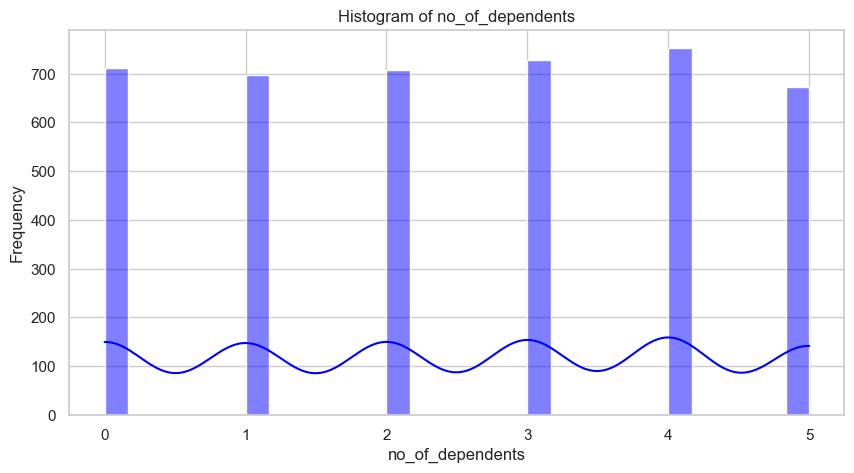

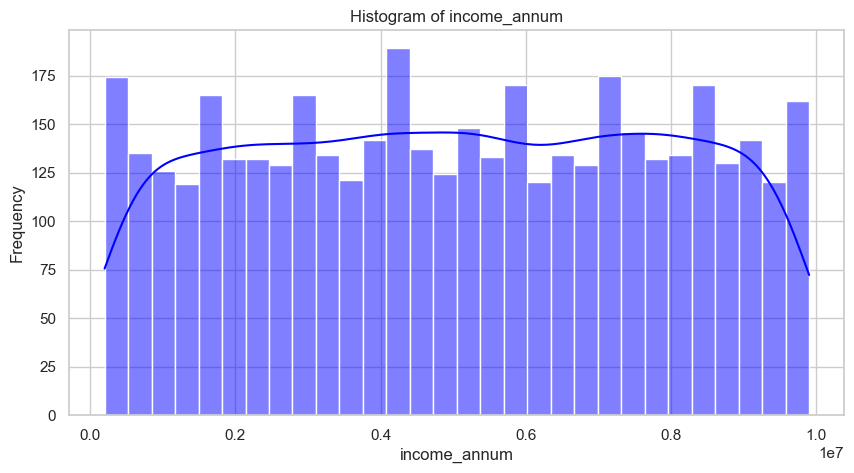

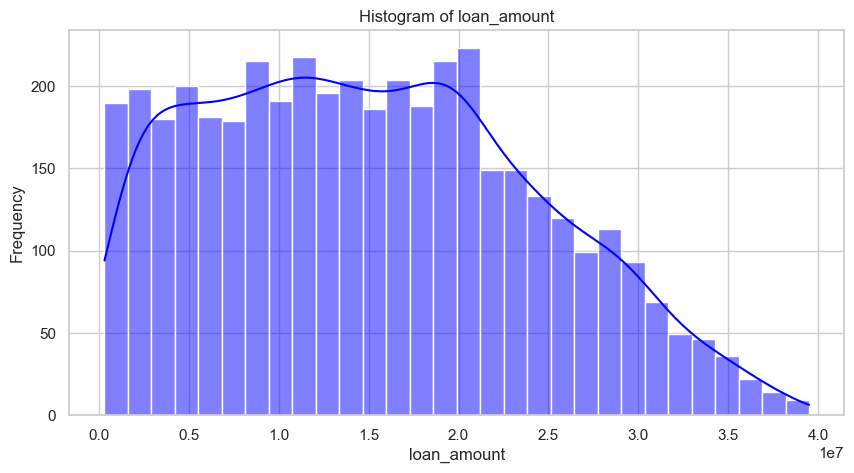

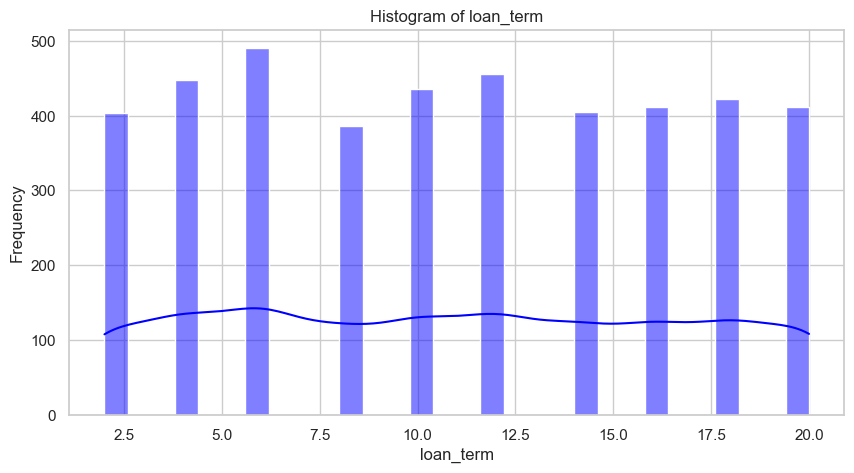

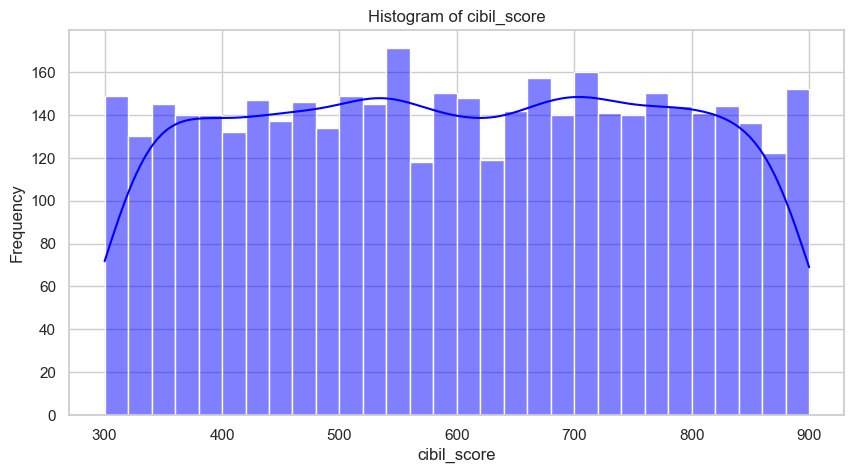

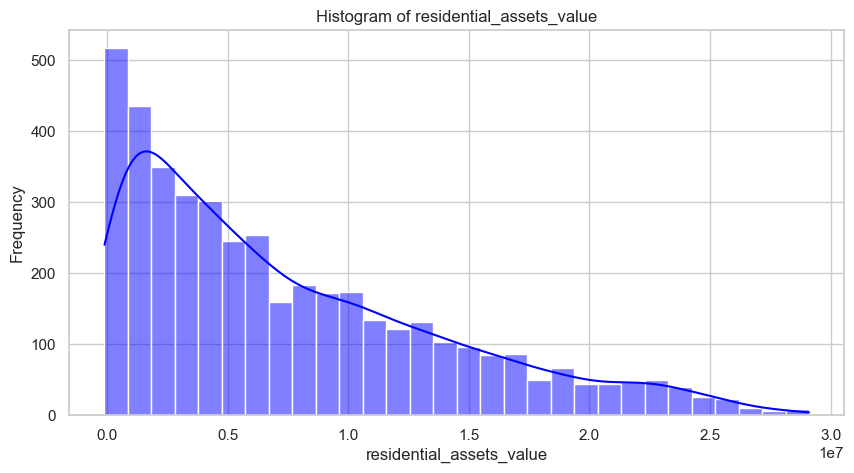

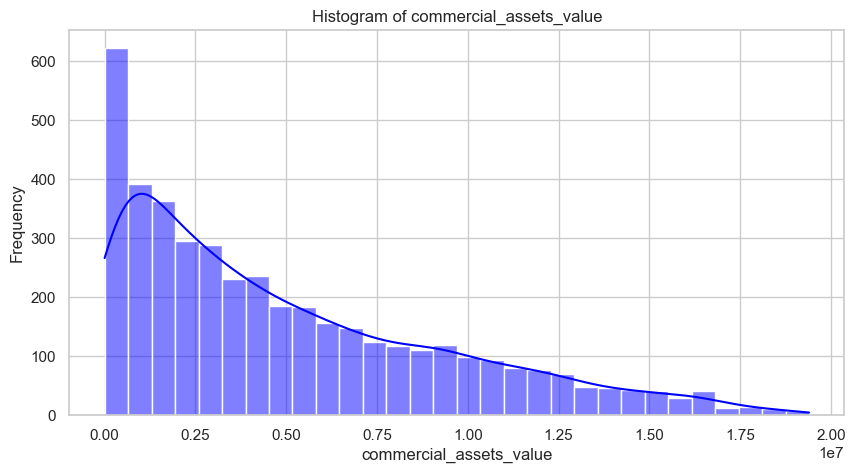

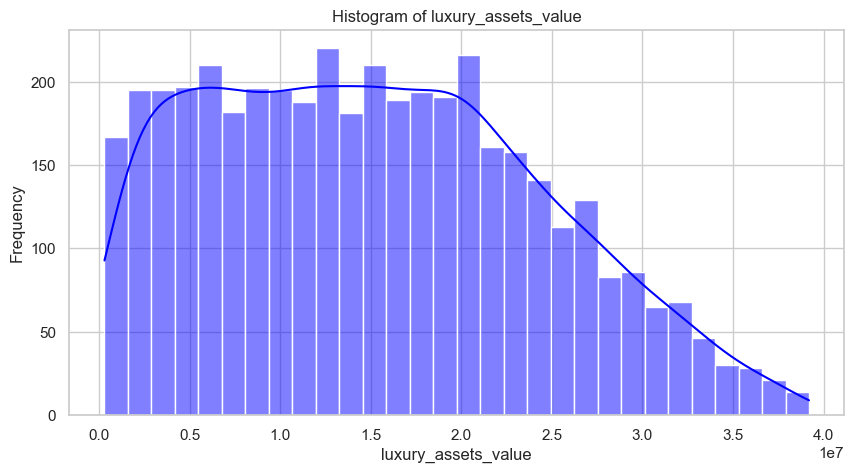

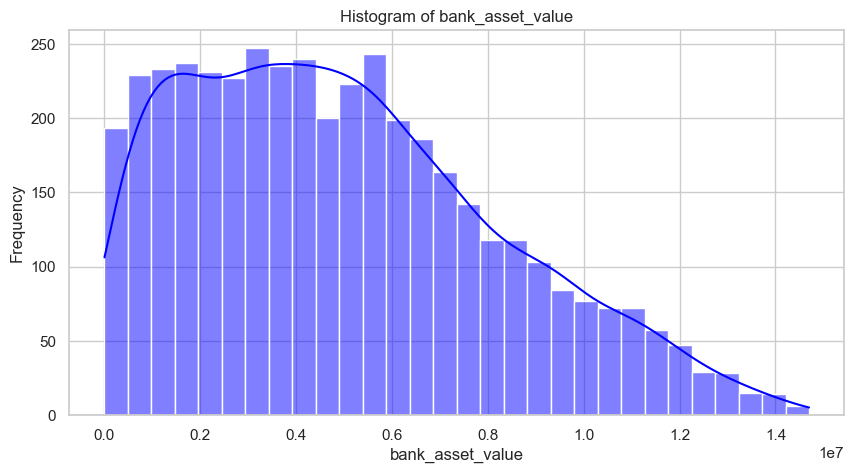

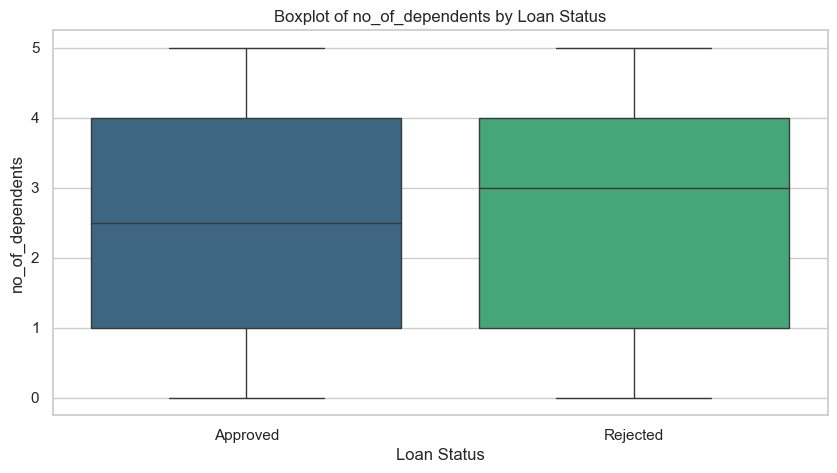

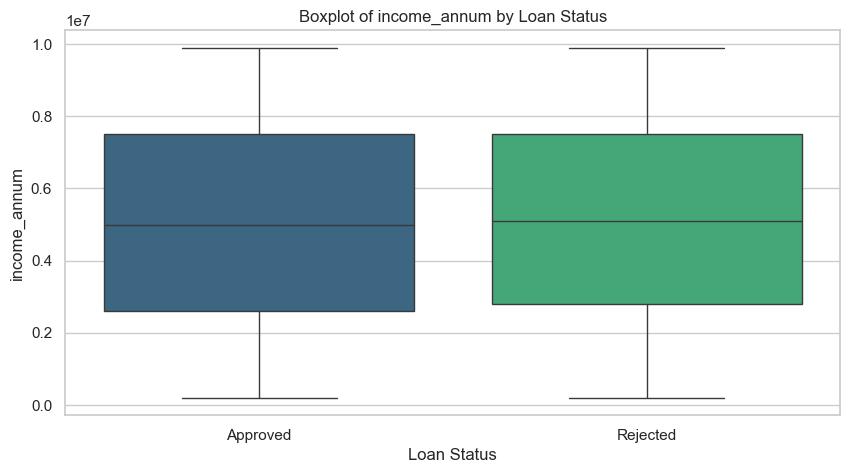

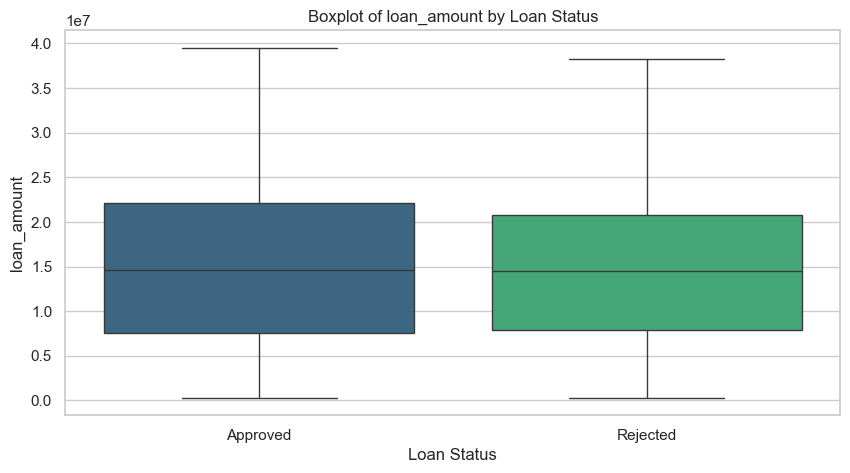

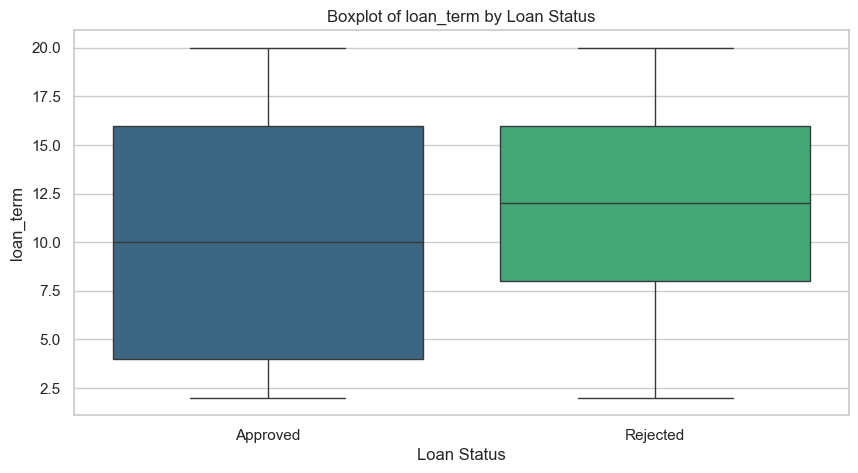

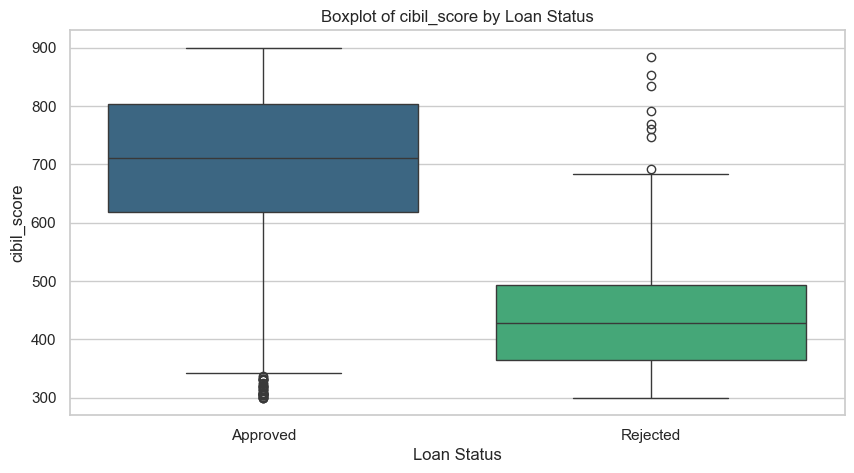

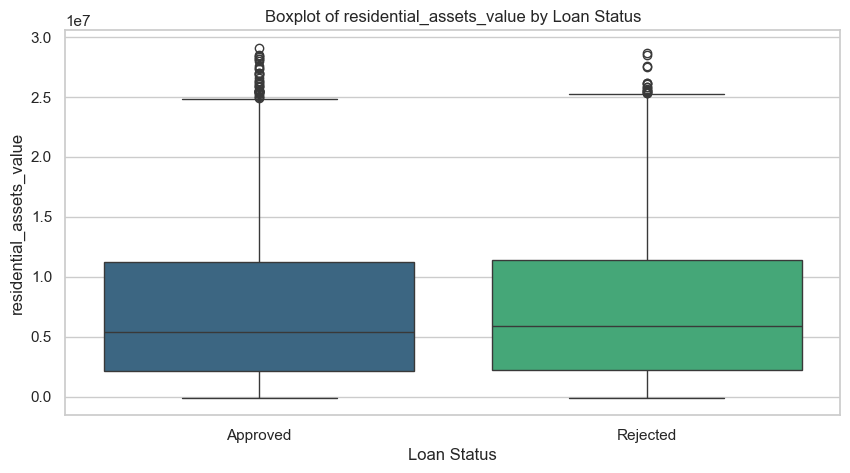

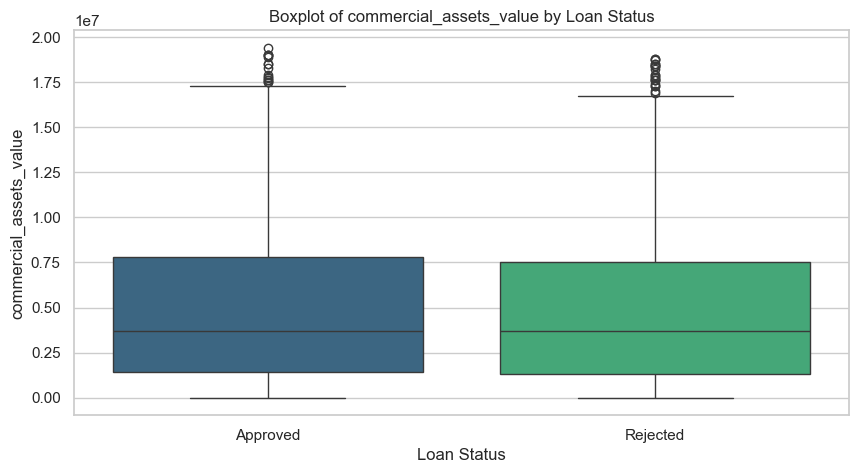

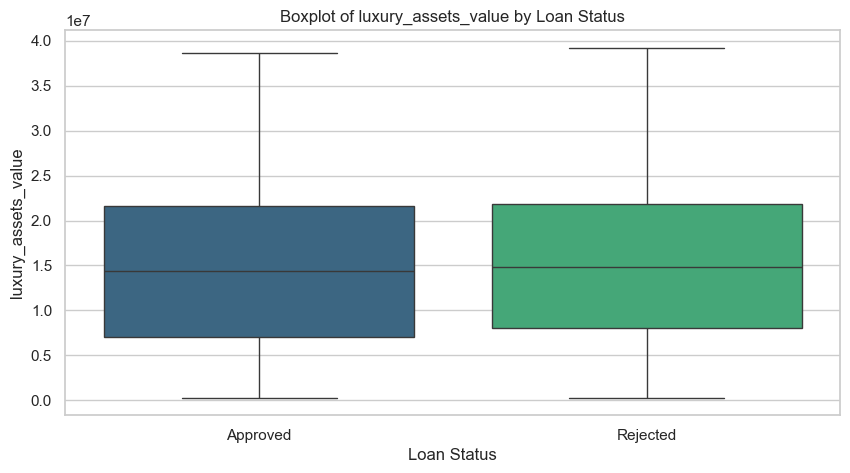

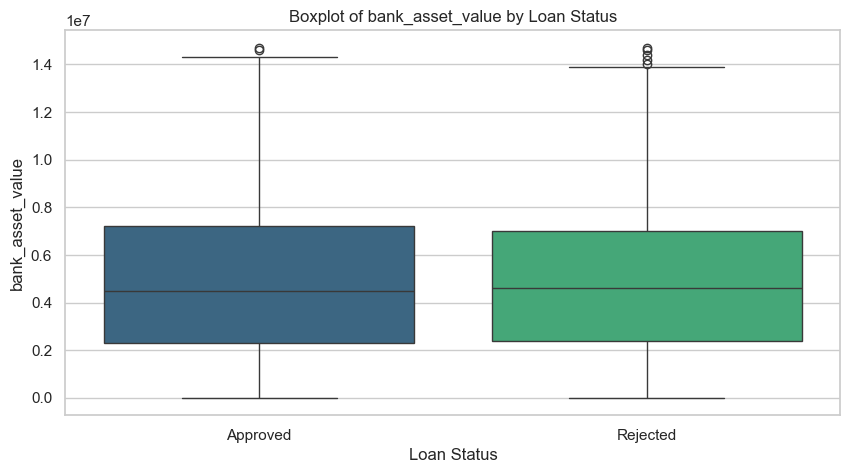

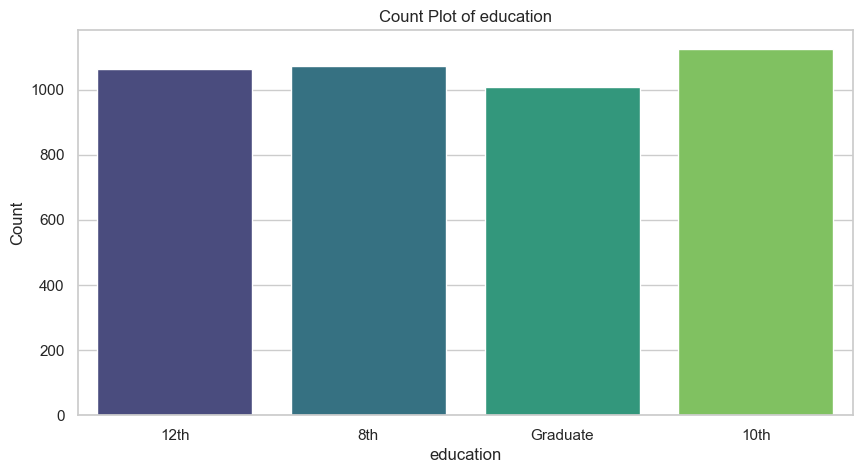

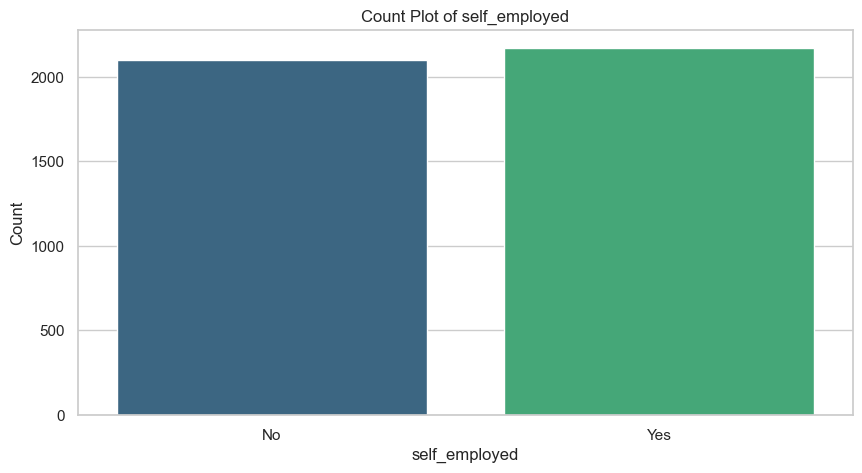

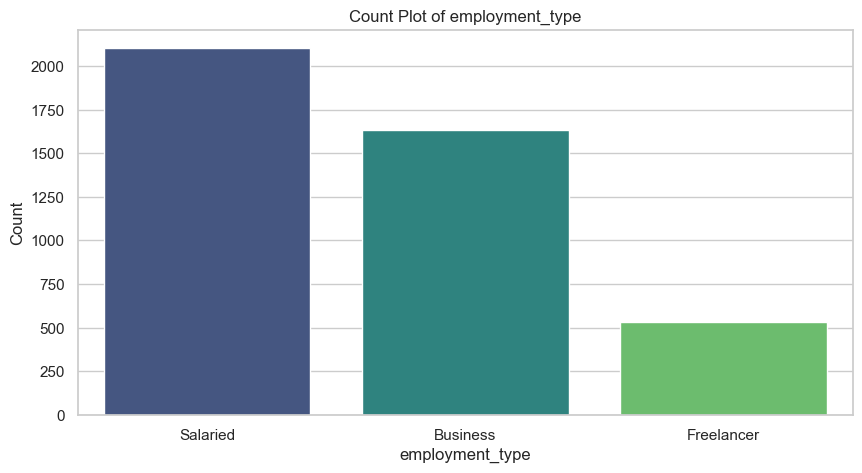

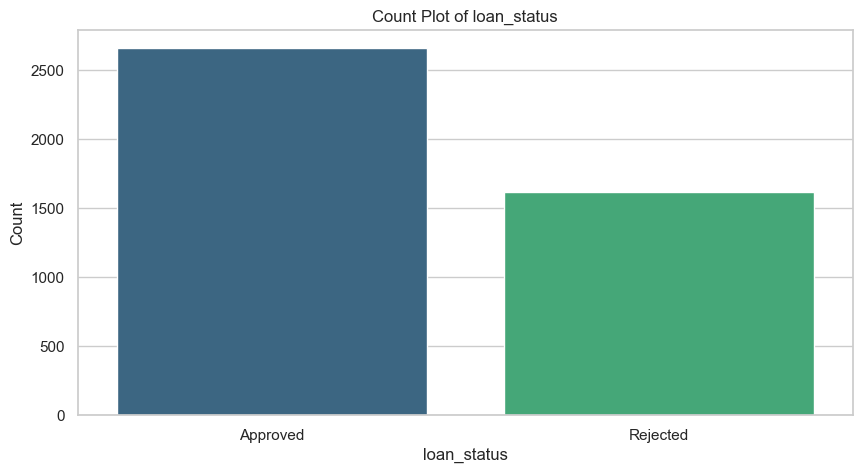

In [3]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Define the features for analysis (you can add more features as needed)
features_for_analysis = [
    'no_of_dependents',
    'income_annum',
    'loan_amount',
    'loan_term',
    'cibil_score',
    'residential_assets_value',
    'commercial_assets_value',
    'luxury_assets_value',
    'bank_asset_value',
]

# Plot histograms for numerical features
for feature in features_for_analysis:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True, bins=30, color='blue')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Plot boxplots for numerical features
for feature in features_for_analysis:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='loan_status', y=feature, data=df, palette='viridis')
    plt.title(f'Boxplot of {feature} by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(feature)
    plt.show()

# Plot count plots for categorical features
categorical_features = ['education', 'self_employed', 'employment_type', 'loan_status']
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=feature, data=df, palette='viridis')
    plt.title(f'Count Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


In [4]:
# Relation b/w Loan Status and income_annum
temp = df.groupby('loan_status')['income_annum'].agg(['mean', 'median']).round(2)
temp

mean     median
loan_status                       
Approved     5025903.61  5000000.0
Rejected     5113825.17  5100000.0

In [5]:
mean_abs_diff_perc = abs(temp['mean'].iloc[0] - temp['mean'].iloc[1]) / temp['mean'].iloc[0] * 100
print(f'Mean Absolute Difference for Annual Income b/w Approved and Rejected Loan Applications as a percentage of Mean Annual Income for Approved Loans: {round(mean_abs_diff_perc, 2)}%')
print()

median_abs_diff_perc = abs(temp['median'].iloc[0] - temp['median'].iloc[1]) / temp['median'].iloc[0] * 100
print(f'Median Absolute Difference for Annual Income b/w Approved and Rejected Loan Applications as a percentage of Median Annual Income for Approved Loans: {round(mean_abs_diff_perc, 2)}%')

Mean Absolute Difference for Annual Income b/w Approved and Rejected Loan Applications as a percentage of Mean Annual Income for Approved Loans: 1.75%

Median Absolute Difference for Annual Income b/w Approved and Rejected Loan Applications as a percentage of Median Annual Income for Approved Loans: 1.75%


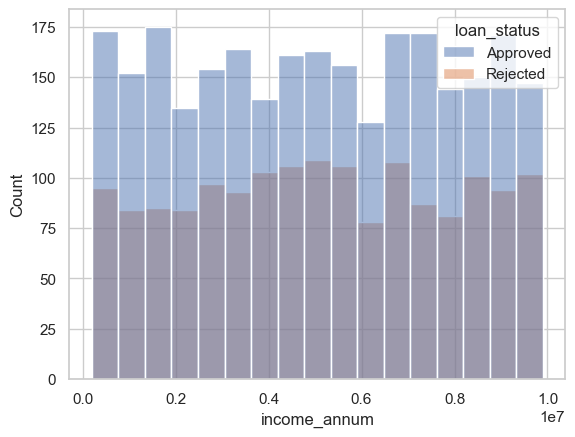

In [6]:
# Plotting the histogram of income_annum accross both loan statuses
sns.histplot(data=df, x='income_annum', hue='loan_status')
plt.show()

In [7]:
# Checking if the above observation is statistically significant or not:
def mann_whitney_test(df, column, status1, status2, alpha=0.05):
    loans_status1 = df.loc[df['loan_status'] == status1]
    loans_status2 = df.loc[df['loan_status'] == status2]

    t_stat, p_value = mannwhitneyu(loans_status1[column], loans_status2[column]) # Using Non-Parametric version because the data doesn't satisfy the assumptions of the parametric test.

    print(f"T-statistic for {column}: {t_stat}, P-value: {p_value}")
    print()

    if p_value < alpha:
        print(f"Reject the null hypothesis. {column} has a significant difference in medians.")
        print(f"{column} and loan status are dependent!")
    else:
        print(f"Fail to reject the null hypothesis. There is no significant difference in medians for {column}.")
        print(f"{column} and loan status are independent!")
    print()

mann_whitney_test(df, 'income_annum', 'Approved', 'Rejected')

T-statistic for income_annum: 2103655.0, P-value: 0.3252248943980307

Fail to reject the null hypothesis. There is no significant difference in medians for income_annum.
income_annum and loan status are independent!



In [8]:
# Relation b/w Loan Status and no_of_dependents
temp = df.groupby('loan_status')['no_of_dependents'].agg(['mean', 'median']).round(2)
temp

mean  median
loan_status              
Approved     2.47     2.5
Rejected     2.54     3.0

In [9]:
# Again, from above the values accross both the group seem pretty close with not much difference. Let's check the statistical significance for the abvoe inference.
mann_whitney_test(df, 'no_of_dependents', 'Approved', 'Rejected')

T-statistic for no_of_dependents: 2096505.5, P-value: 0.2366314772042042

Fail to reject the null hypothesis. There is no significant difference in medians for no_of_dependents.
no_of_dependents and loan status are independent!



In [10]:
# From the above plots, cibil score seem to be drastically different across both groups.
temp = df.groupby('loan_status')['cibil_score'].agg(['mean', 'median']).round(2)
temp

mean  median
loan_status                
Approved     703.46   711.0
Rejected     429.47   429.0

In [11]:
mann_whitney_test(df, 'cibil_score', 'Approved', 'Rejected')

T-statistic for cibil_score: 4110508.0, P-value: 0.0

Reject the null hypothesis. cibil_score has a significant difference in medians.
cibil_score and loan status are dependent!



In [12]:
# Performing the Statistical test for the remaining columns as well to check the dependence/independence w.r.t the target variable.
columns = ['loan_term', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
for col in columns:
    mann_whitney_test(df, col, 'Approved', 'Rejected')
    print('===============================================================================')

T-statistic for loan_term: 1850883.5, P-value: 6.587271074770604e-14

Reject the null hypothesis. loan_term has a significant difference in medians.
loan_term and loan status are dependent!

T-statistic for residential_assets_value: 2100197.0, P-value: 0.28357655503946544

Fail to reject the null hypothesis. There is no significant difference in medians for residential_assets_value.
residential_assets_value and loan status are independent!

T-statistic for commercial_assets_value: 2165061.0, P-value: 0.5558412398540895

Fail to reject the null hypothesis. There is no significant difference in medians for commercial_assets_value.
commercial_assets_value and loan status are independent!

T-statistic for luxury_assets_value: 2098047.5, P-value: 0.2595945521246562

Fail to reject the null hypothesis. There is no significant difference in medians for luxury_assets_value.
luxury_assets_value and loan status are independent!

T-statistic for bank_asset_value: 2116648.0, P-value: 0.51506103488

**Inferences**

1. Distribution for no_of_dependents, income_annum, loan_term, & cibil_score seems uniform with not much skewness observed. This observation is quite surprising specifically, for income_annum because generally, annual incomes follow right skewed distributions.
2. Asset value columns like, residential_assets_value, commercial_assets_value, luxury_assets_value, and bank_asset_value follows a right (positive) skewed distribution and this makes sense as well.
3. There seems to be no relation b/w the Annual Income of the applicant and the loan approval status. 
    * The average and median annual incomes for applicants whose loan status was approved is : 5025903.61 &	5000000.0 respectively.
    * The average and median annual incomes for applicants whose loan status was rejected is : 5113825.17 &	5100000.0 respectively.
    * Mean Absolute Difference for Annual Income b/w Approved and Rejected Loan Applications as a percentage of Mean Annual Income for Approved Loans: 1.75%
    * Median Absolute Difference for Annual Income b/w Approved and Rejected Loan Applications as a percentage of Median Annual Income for Approved Loans: 1.75% 
    
4. There's very slight difference b/w the no_of_dependents across the two loan statuses. Hence, the loan_status is independent of the no_of_dependents:
    * The average and median no_of_dependents for applicants whose loan status was approved is : 2.47 &	2.5 respectively.
    * The average and median no_of_dependents for applicants whose loan status was rejected is : 2.54 &	3 respectively.
5. Basis the above boxplots & statistical tests, a similar reasoning as above can be given for some of the other columns like commercial_assets_value, luxury_assets_value and bank_asset_value.
6. From the above analysis, the two variables which on which the loan status is dependent are: cibil_score and loan_term.

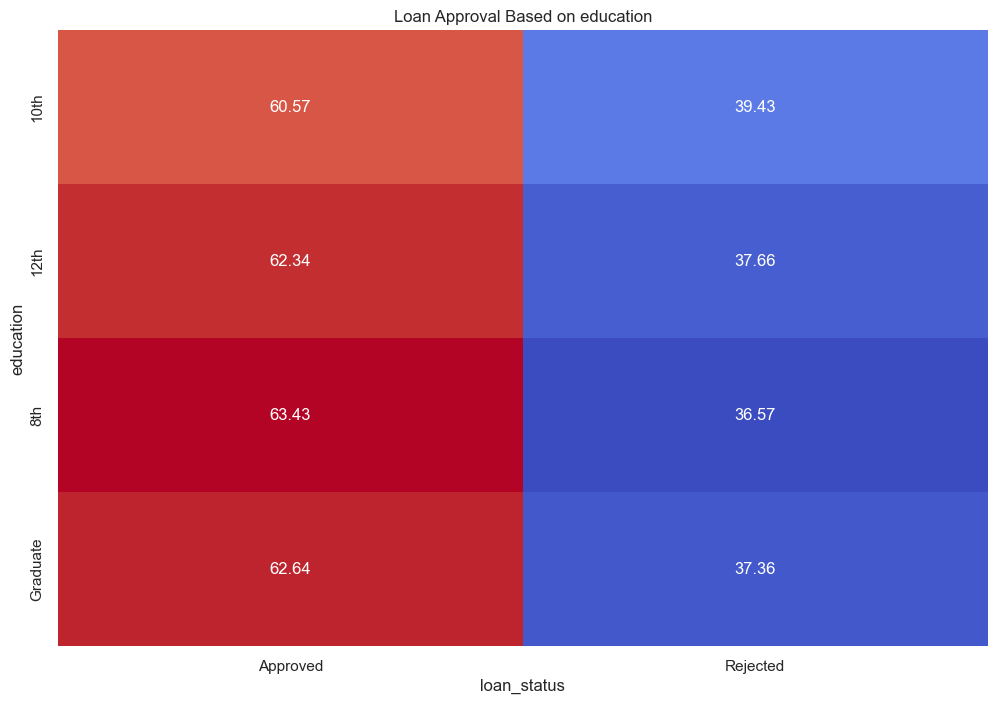

Chi-squared test for education: Chi2 Stat = 0.1865115707216947, P-value = 0.97973684634103
education and Loan Status are independent.
Fail to reject the null hypothesis!



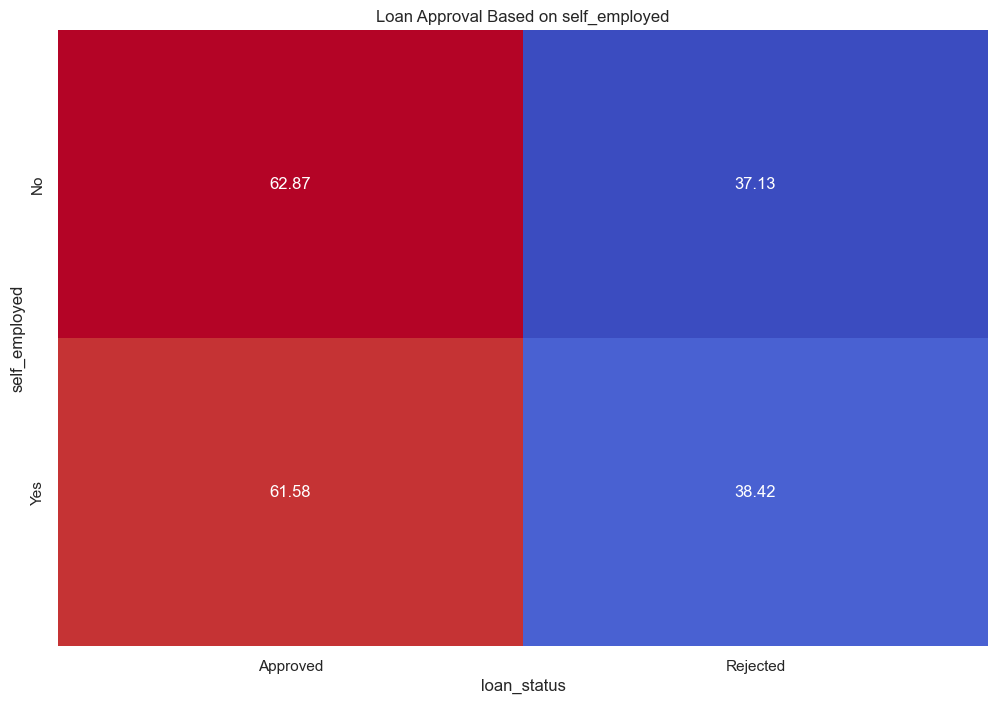

Chi-squared test for self_employed: Chi2 Stat = 0.001880552527845047, P-value = 0.9654103080746723
self_employed and Loan Status are independent.
Fail to reject the null hypothesis!



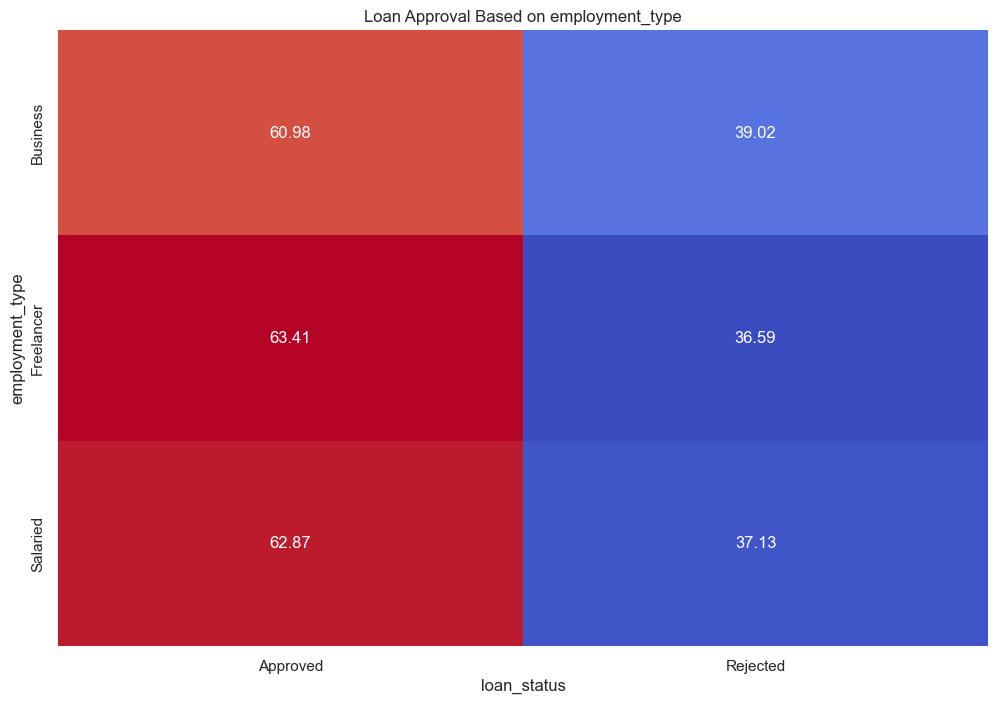

Chi-squared test for employment_type: Chi2 Stat = 0.1395670216858101, P-value = 0.9325956949091864
employment_type and Loan Status are independent.
Fail to reject the null hypothesis!



In [13]:
# Define a function to perform the chi-squared test
def perform_chi_squared_test(cross_tab):
    chi2, p, _, _ = chi2_contingency(cross_tab)
    return chi2, p

# Additional Analysis based on Categorical Features
def analyze_categorical_features(df):
    for column in df.columns:
        if column == 'loan_status':
            continue
        if df[column].dtype == 'O':  # Check if the column is of object type (categorical)
            cross_tab = pd.crosstab(df[column], df['loan_status'], normalize='index') * 100

            # Visualize the cross-tabulation
            plt.figure(figsize=(12, 8))
            sns.heatmap(cross_tab, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
            plt.title(f'Loan Approval Based on {column}')
            plt.show()

            chi2_stat, p_value = perform_chi_squared_test(cross_tab)
            print(f"Chi-squared test for {column}: Chi2 Stat = {chi2_stat}, P-value = {p_value}")

            alpha = 0.05
            ho = f"{column} and Loan Status are independent."
            ha = f"{column} and Loan Status are dependent."

            if p_value < alpha:
                print(ha)
                print('Reject the null hypothesis!')
            else:
                print(ho)
                print('Fail to reject the null hypothesis!')
            
            print()

analyze_categorical_features(df)

### Correlation & Multivariate Analysis

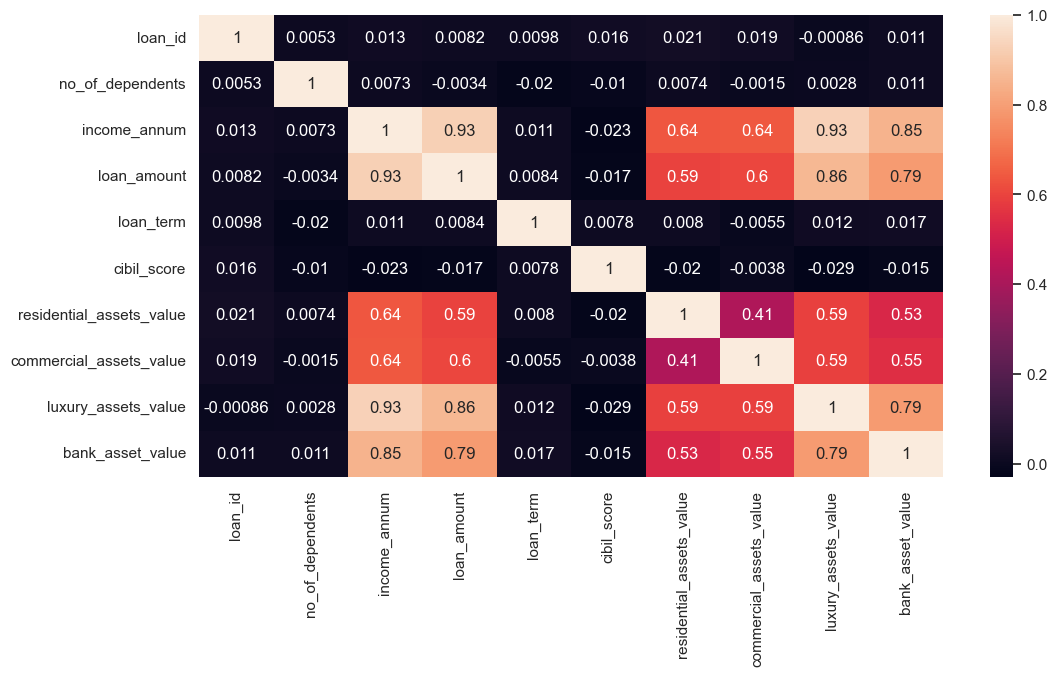

In [14]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True)
plt.show()

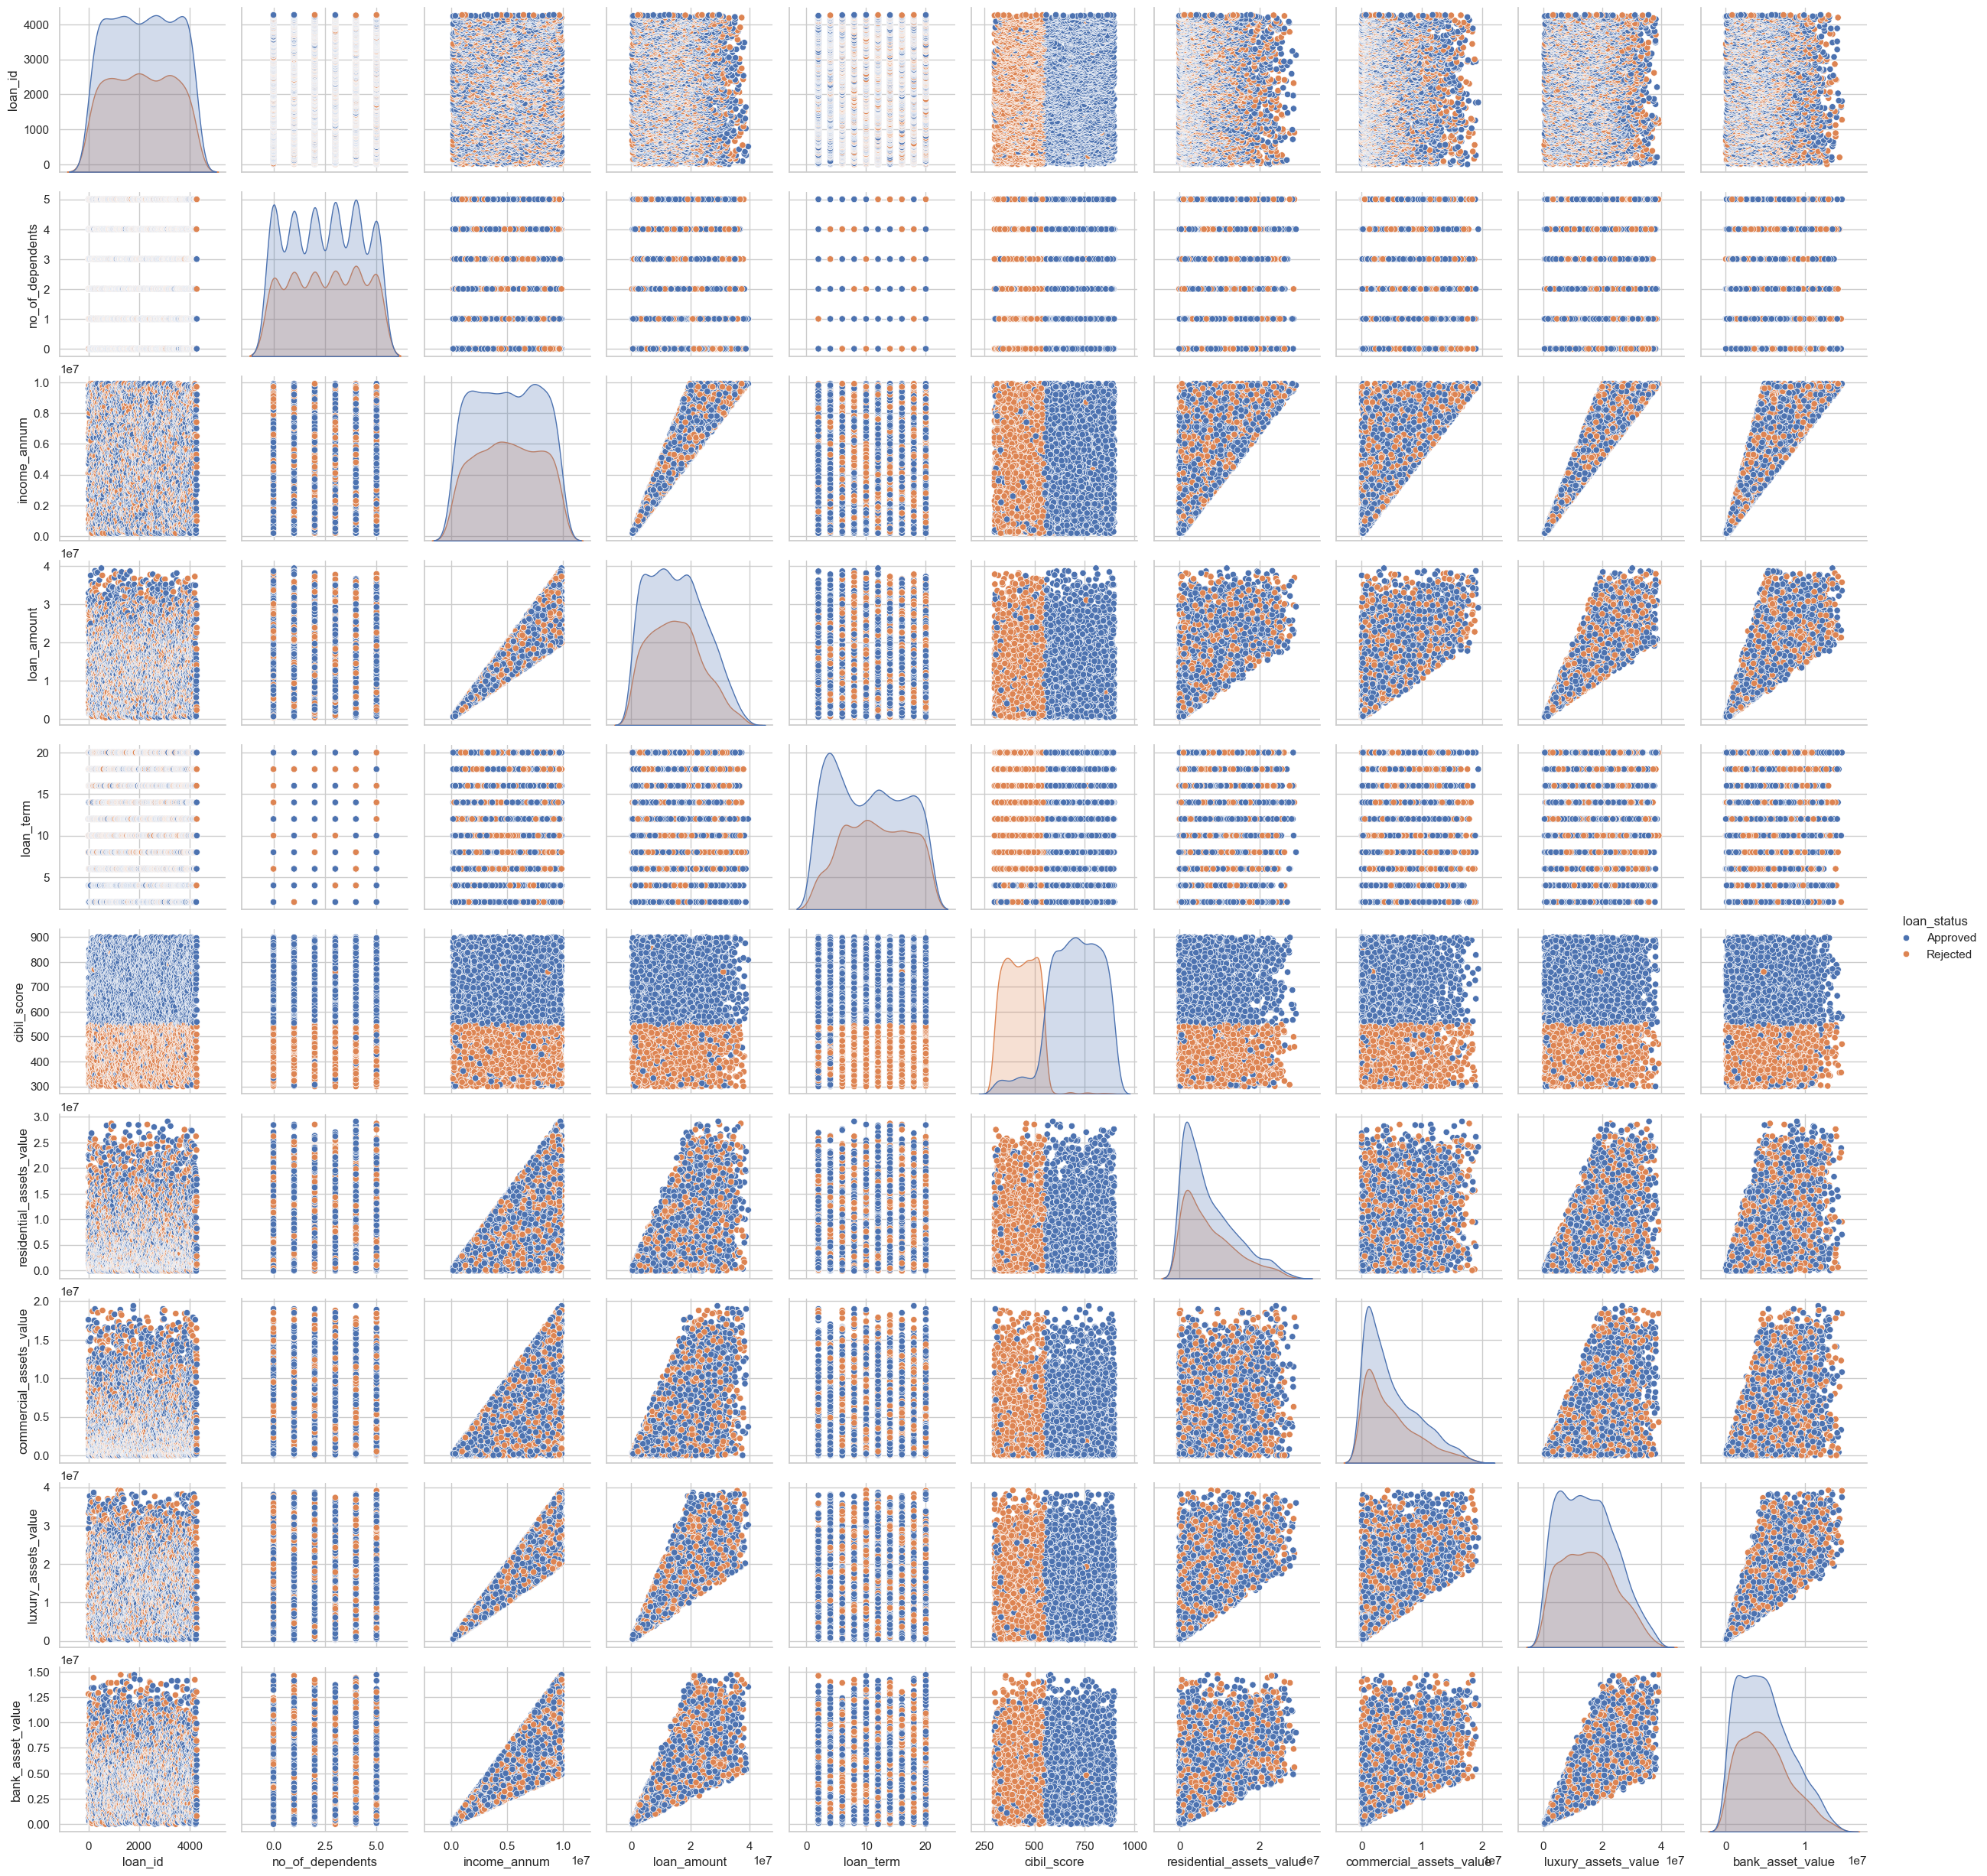

In [15]:
sns.pairplot(df, hue="loan_status")
plt.show()

**Inferences contd.**

7. Upon further analysing, it seems like there's no relation between the loan_status and any of the categorical features like education, self-employed, type of employment.

8. Apart from that, there's a strong positive correlation b/w loan amount and assets columns, income_annum and asset columns, loan_amount and income_annum, which also makes sense because if someone's having a higher income then it's very likely that their assets would also be of high value and same could be said for the opposite as well.

9. Based on the above analysis, we'll proceed with only 2 predictor variables: **cibil_score & loan_term.**

# 2. Machine Learning Modelling

In [16]:
# Based on EDA insights,
selected_features = ['cibil_score', 'loan_term']

# 3. Train Binary Classification Model
X = df[selected_features]
y = df['loan_status']


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Baseline Model: Logistic Regression
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train_scaled, y_train)
baseline_predictions = baseline_model.predict(X_test_scaled)

# Evaluate Baseline Model
print("Baseline Model - Logistic Regression:")
print("\nClassification Report:\n", classification_report(y_test, baseline_predictions))
print()


Baseline Model - Logistic Regression:

Classification Report:
               precision    recall  f1-score   support

    Approved       0.93      0.93      0.93       536
    Rejected       0.88      0.88      0.88       318

    accuracy                           0.91       854
   macro avg       0.90      0.90      0.90       854
weighted avg       0.91      0.91      0.91       854




In [18]:
# 2. Ensemble Model: XGBoost
y = df['loan_status'].map(lambda x : 1 if x=='Approved' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ensemble_model = XGBClassifier(random_state=42)
ensemble_model.fit(X_train_scaled, y_train)
ensemble_predictions = ensemble_model.predict(X_test_scaled)

# Evaluate Ensemble Model
print("Ensemble Model - XGBoost:")
print("\nF1 Score:", f1_score(y_test, ensemble_predictions))
print("\nClassification Report:\n", classification_report(y_test, ensemble_predictions))

Ensemble Model - XGBoost:

F1 Score: 0.9644194756554307

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       318
           1       0.97      0.96      0.96       536

    accuracy                           0.96       854
   macro avg       0.95      0.95      0.95       854
weighted avg       0.96      0.96      0.96       854



In [19]:
# 3. Fine-tune Ensemble Model (XGBoost) with Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}
grid_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params = grid_search.best_params_

# Evaluate Fine-tuned Model
tuned_model = XGBClassifier(**best_params, random_state=42)
tuned_model.fit(X_train_scaled, y_train)
tuned_predictions = tuned_model.predict(X_test_scaled)

print("Fine-tuned Model - XGBoost:")
print("Best Hyperparameters:", best_params)
print("\nF1 Score:", f1_score(y_test, tuned_predictions))
print("\nClassification Report:\n", classification_report(y_test, tuned_predictions))

Fine-tuned Model - XGBoost:
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}

F1 Score: 0.962756052141527

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       318
           1       0.96      0.96      0.96       536

    accuracy                           0.95       854
   macro avg       0.95      0.95      0.95       854
weighted avg       0.95      0.95      0.95       854



**Clearly, the default model outperforms the hyperparamter-tuned model.**

# 3. Deciding the best threshold basis the f1-score

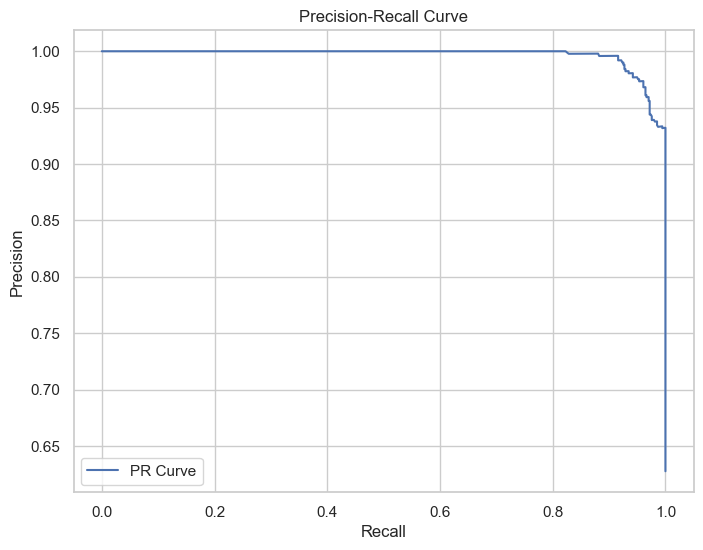

Best Threshold: 0.55589014


In [20]:
# 2. Obtain predicted probabilities for the positive class
y_probs = ensemble_model.predict_proba(X_test_scaled)[:, 1]

# 3. Plot the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 4. Choose the threshold that maximizes F1 score or balances precision and recall
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[f1_scores.argmax()]

print("Best Threshold:", best_threshold)

In [21]:
df[df['loan_status'] =='Rejected'][['cibil_score', 'loan_term']]

cibil_score  loan_term
1             417          8
2             506         20
3             467          8
4             382         20
5             319         10
...           ...        ...
4258          346         16
4259          509         14
4262          540         20
4264          317         12
4266          457         18

[1613 rows x 2 columns]

In [22]:
# Obtain predicted probabilities for the positive class
y_probs = ensemble_model.predict_proba(X_test_scaled)[:, 1]

# Apply the best threshold
y_pred = (y_probs > best_threshold).astype(int)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

print("\nF1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[304  14]
 [ 22 514]]

F1 Score: 0.9661654135338346

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       318
           1       0.97      0.96      0.97       536

    accuracy                           0.96       854
   macro avg       0.95      0.96      0.96       854
weighted avg       0.96      0.96      0.96       854



In [23]:
# Dump the model & standard scaler
pkl.dump(ensemble_model, open('model.pkl', 'wb'))
pkl.dump(scaler, open('scaler.pkl', 'wb'))

# 4. Evaluating the model with sample input

In [24]:
sample_data = {'cibil_score': [750], 'loan_amount': [50000], 'income_annum': [60000], 'employment_type_Salaried': [1],
               'employment_type_Business': [0], 'employment_type_Freelancer': [0], 'loan_term': [10]}

# Create a DataFrame
sample_df = pd.DataFrame(sample_data)
selected_features = ['cibil_score', 'loan_term']

sample_df_scaled = scaler.transform(sample_df[selected_features])

# Make predictions
sample_predictions = ensemble_model.predict(sample_df_scaled)
print("Sample Predictions:", *['Congratulations, your loan is Approved!' if sample_predictions else 'Sorry, your application for loan is Rejected!'])

Sample Predictions: Congratulations, your loan is Approved!


### If given more time, additional analyses could include:

1. **Multivariate Analysis:**
   - Investigating the relationship between 'employment_type,' 'income_annum,' and 'loan_status' to discern patterns among different employment categories. This could provide insights into the financial stability and reliability of various employment types in loan approval.
   - Exploring interactions between 'education,' 'employment_type,' and 'cibil_score' to understand how educational qualifications may influence employment types and credit scores, which, in turn, impact loan approval.

2. **Feature Engineering:**
   - Creating new features or transforming existing ones to capture complex relationships. For instance, deriving a debt-to-income ratio by combining 'loan_amount' and 'income_annum' might offer a more nuanced understanding of an applicant's financial health.

3. **Advanced Statistical Testing:**
   - Conducting more advanced statistical tests such as two-way ANOVA or chi-squared tests for independence to unveil hidden relationships among multiple categorical variables.

4. **Ensemble Model Exploration:**
   - Experimenting with other ensemble models like Gradient Boosting Machines (GBM) or AdaBoost to compare performance and identify potential improvements over Random Forest and XGBoost.


5. **Feature Importance and Impact:**
   - Analyzing feature importance and impact on model predictions to understand which variables significantly influence the loan approval decision. This insight aids in better interpretability and trustworthiness of the model.

6. **Cross-Validation Strategies:**
   - Implementing more sophisticated cross-validation strategies, such as stratified K-fold, to ensure robust model evaluation and reduce overfitting concerns.

8. **Predictive Analytics on Customer Segmentation:**
   - Leveraging clustering techniques to segment customers based on their financial profiles and analyzing how these segments correlate with loan approval. This could provide valuable insights for targeted marketing strategies or personalized financial products.